Portrait Segmentation Model with PyTroch Lighting. Check out another version trained with transfer learning using the Segmentation-Models-Pytorch package:

In [3]:
pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 17.7 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
#core pacakges
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import cv2
from shutil import copyfile
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip '/content/drive/MyDrive/!personalMLProject/portraitSegmentation/portraitSegData/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: ytrain/13698.png        
  inflating: ytrain/13699.png        
  inflating: ytrain/13700.png        
  inflating: ytrain/13701.png        
  inflating: ytrain/13702.png        
  inflating: ytrain/13703.png        
  inflating: ytrain/13704.png        
  inflating: ytrain/13705.png        
  inflating: ytrain/13706.png        
  inflating: ytrain/13707.png        
  inflating: ytrain/13708.png        
  inflating: ytrain/13709.png        
  inflating: ytrain/13710.png        
  inflating: ytrain/13711.png        
  inflating: ytrain/13712.png        
  inflating: ytrain/13713.png        
  inflating: ytrain/13714.png        
  inflating: ytrain/13715.png        
  inflating: ytrain/13716.png        
  inflating: ytrain/13717.png        
  inflating: ytrain/13718.png        
  inflating: ytrain/13719.png        
  inflating: ytrain/13720.png        
  inflating: ytrain/13721.png        
  inflating: ytrain/13722.png        

In [7]:
xtest_dir = '/content/xtest'
xtrain_dir = '/content/xtrain'
ytest_dir = '/content/ytest'
ytrain_dir = '/content/ytrain'

In [8]:
def visualize_dataset(aDataset):
  fig, axes = plt.subplots(5, 2, figsize=(10, 20))

  for i in range(5):
    random_index = random.randint(0, len(aDataset) - 1)
    image, mask = aDataset[random_index]

    numpy_mask = mask.detach().numpy()
    numpy_image = image.detach().numpy()*255.0

    #switch channel to last position for visualization
    if numpy_image.shape[0] == 3:
        numpy_image = np.transpose(numpy_image, (1, 2, 0))
    if numpy_mask.shape[0] == 1:
        numpy_mask = np.transpose(numpy_mask, (1,2,0))

    numpy_image = numpy_image.astype(np.uint8)

    axes[i, 0].imshow(numpy_image)
    axes[i, 0].set_title("Image")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(numpy_mask, cmap='gray')
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis('off')

    # print (f'image shape {numpy_image.shape}')
    # print (f'mask shape {numpy_mask.shape}')
    #print(f'mask tensor {mask}')
    unique_vals_mask = torch.unique(mask)
    #print(f'mask tensor unqiue vals {unique_vals_mask}')

    #print(f'image tensor {image}')
    unique_vals_img = torch.unique(image)
    #print(f'image tensor unqiue vals {unique_vals_img}')

  plt.tight_layout()
  plt.show()

In [9]:
class portraitSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Load images as uint8
        image = np.array(Image.open(img_path).convert('RGB'), dtype=np.uint8)
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.uint8)

        image = image/255.0
        #print(image)

        # Convert mask to binary values
        mask[mask == 255] = 1

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']  # Should be torch.Tensor
            mask = augmented['mask']    # Should be torch.Tensor

        else:
            # If no transform, convert to tensor
            image = torch.from_numpy(image.transpose(2, 0, 1)).float()
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        # # Ensure image is float32 and scaled properly
        image = image.float()
        mask = mask.float()

        return image, mask

In [10]:
#alubmentations transformations
train_augment = A.Compose([
    #alubmentation normalize distinguishes images(3 chan) from masks (1 chan)
    A.Rotate(limit=35, p=0.2),
    A.HorizontalFlip(p=0.2),
    A.VerticalFlip(p=0.1),
    A.Affine(scale=1.0, translate_percent=0.1, shear=5, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, p=1.0),
    ToTensorV2(),
])

val_preprocess = A.Compose([
    ToTensorV2(),
])


In [11]:
#takes in path for train and its mask dir, split img/mask pathes for train/val split. Stored in val folder
def train_dir_to_train_val_split(train_img_dir, train_mask_dir):
  # List all files in the image directory
  image_filenames = os.listdir(train_img_dir)

  mask_filenames = os.listdir(train_mask_dir) #can do this because mask, image have the same names

  # Sort and match image files with mask files by name
  image_filenames.sort()
  mask_filenames.sort()

  train_images, val_images, train_masks, val_masks = train_test_split(
    image_filenames, mask_filenames, test_size=0.2, random_state=42
  )

  trainSplit_image_dir = '/content/xtrain_split'
  val_image_dir = '/content/xval_split'
  trainSplit_mask_dir = '/content/ytrain_split'
  val_mask_dir = '/content/yval_split'

  os.makedirs(trainSplit_image_dir, exist_ok=True)
  os.makedirs(val_image_dir, exist_ok=True)
  os.makedirs(trainSplit_mask_dir, exist_ok=True)
  os.makedirs(val_mask_dir, exist_ok=True)

  # Copy training files
  for img, mask in zip(train_images, train_masks):
      copyfile(os.path.join(train_img_dir, img), os.path.join(trainSplit_image_dir, img))
      copyfile(os.path.join(train_mask_dir, mask), os.path.join(trainSplit_mask_dir, mask))

  # Copy validation files
  for img, mask in zip(val_images, val_masks):
      copyfile(os.path.join(train_img_dir, img), os.path.join(val_image_dir, img))
      copyfile(os.path.join(train_mask_dir, mask), os.path.join(val_mask_dir, mask))

  print(f'Training images: {len(train_images)}, Validation images: {len(val_images)}')


In [12]:
#train test split with new folders
train_dir_to_train_val_split(xtrain_dir, ytrain_dir)

Training images: 14958, Validation images: 3740


In [13]:
# Initialize dataset with transformations and preprocessing function
xtrain_dir = '/content/xtrain_split'
ytrain_dir = '/content/ytrain_split'
xval_dir = '/content/xval_split'
yval_dir = '/content/yval_split'

train_dataset = portraitSegmentationDataset(image_dir=xtrain_dir, mask_dir=ytrain_dir, transform=train_augment)
val_dataset = portraitSegmentationDataset(image_dir=xval_dir, mask_dir=yval_dir, transform=val_preprocess)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


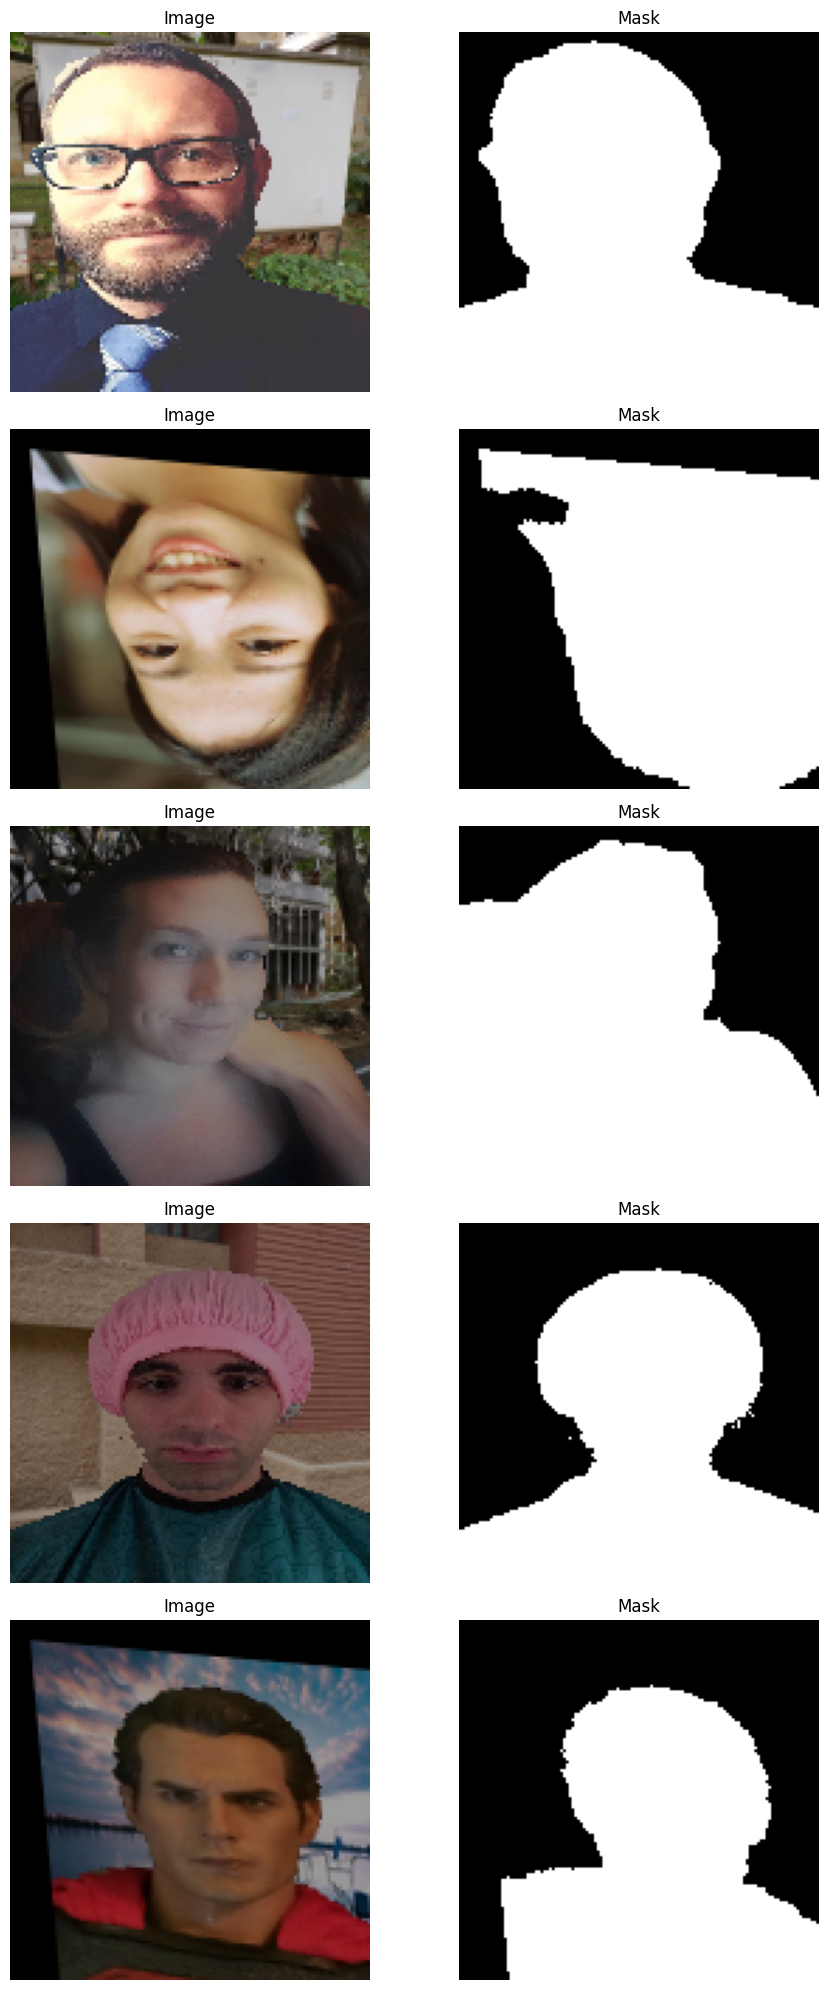

In [14]:
visualize_dataset(train_dataset)

In [41]:
#unet class
class UNet(pl.LightningModule):
    #layers definition
    def __init__(self, in_channels=3, out_channels=1): #constructor for uNetDenoise
        super().__init__() #constructor of parent class to init inherited attributes
        #Encoder portion, with 256x256x3 input. Padding: same for 3x3 convolutions

        self.in_channels = in_channels
        self.out_channels = out_channels
        #1st downsample layer
        self.conv11 = nn.Conv2d(self.in_channels, 64,kernel_size=3, padding=1) #dataset images are black and white
        self.conv12 = nn.Conv2d(64,64, kernel_size=3, padding=1) #keep padding same, (kernselSize-1)/2
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        #2nd downsample layer
        self.conv21 = nn.Conv2d(64,128,kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(128,128,kernel_size=3, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        #3rd downsample layer
        self.conv31 = nn.Conv2d(128,256,kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(256,256,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2)

        #4th downsample layer
        self.conv41 = nn.Conv2d(256,512,kernel_size=3, padding=1)
        self.conv42 = nn.Conv2d(512,512,kernel_size=3, padding=1)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2)

        #bottle neck
        self.conv51 = nn.Conv2d(512,1024,kernel_size=3, padding=1)
        self.conv52 = nn.Conv2d(1024,1024,kernel_size=3, padding=1)

        #upsample 1
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #1024, but half
        self.u11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.u12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        #upsample 2
        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.u21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.u22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        #upsample 3
        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.u31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.u32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #upsample 4
        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.u41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.u42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        #output layer
        self.outconv = nn.Conv2d(64, self.out_channels, kernel_size=1) #2 classes: portrait and not portrait

        #loss function
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        #encoder forward
        xconv11 = F.relu(self.conv11(x))
        xconv12 = F.relu(self.conv12(xconv11))
        xpool1 = self.pool1(xconv12)

        xconv21 = F.relu(self.conv21(xpool1))
        xconv22 = F.relu(self.conv22(xconv21))
        xpool2 = self.pool2(xconv22)

        xconv31 = F.relu(self.conv31(xpool2))
        xconv32 = F.relu(self.conv32(xconv31))
        xpool3 = self.pool3(xconv32)

        xconv41 = F.relu(self.conv41(xpool3))
        xconv42 = F.relu(self.conv42(xconv41))
        xpool4 = self.pool4(xconv42)

        xconv51 = F.relu(self.conv51(xpool4))
        xconv52 = F.relu(self.conv52(xconv51))

        #decoder forward
        xup1 = self.upconv1(xconv52)

        #dimension mismatch check:
        if xup1.size() != xconv42.size():
            diffY = xconv42.size()[2] - xup1.size()[2]
            diffX = xconv42.size()[3] - xup1.size()[3]
            xup1 = F.pad(xup1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])

        xu11 = torch.cat([xup1, xconv42], dim=1)
        xd11 = F.relu(self.u11(xu11))
        xd12 = F.relu(self.u12(xd11))

        xup2 = self.upconv2(xd12)
        xu22 = torch.cat([xup2, xconv32], dim=1)
        xd21 = F.relu(self.u21(xu22))
        xd22 = F.relu(self.u22(xd21))

        xup3 = self.upconv3(xd22)
        xu33 = torch.cat([xup3, xconv22], dim=1)
        xd31 = F.relu(self.u31(xu33))
        xd32 = F.relu(self.u32(xd31))

        xup4 = self.upconv4(xd32)
        xu44 = torch.cat([xup4, xconv12], dim=1)
        xd41 = F.relu(self.u41(xu44))
        xd42 = F.relu(self.u42(xd41))

        #output layer
        out = self.outconv(xd42)
        return out

    def training_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self(inputs)
      outputs = torch.squeeze(outputs, 1)
      loss = self.loss_fn(outputs, targets)
      self.log('train_loss', loss, logger=True, prog_bar=True, on_epoch=True)
      return loss
    def validation_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self(inputs)
      outputs = torch.squeeze(outputs, 1)
      loss = self.loss_fn(outputs, targets)
      self.log('val_loss', loss, logger=True, prog_bar=True, on_epoch=True)
      return loss

    def test_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self(inputs)
      outputs = torch.squeeze(outputs, 1)
      loss = self.loss_fn(outputs, targets)
      self.log('test_loss', loss, logger=True, prog_bar=True, on_epoch=True)
          # Visualize a few examples
      if batch_idx < 5:  # Display the first 5 batches
          preds = torch.sigmoid(outputs)
          preds = (preds > 0.5).float()  # Threshold to get binary mask

          # Move tensors to CPU and detach
          inputs_np = inputs.cpu().numpy()
          targets_np = targets.cpu().numpy()
          preds_np = preds.cpu().numpy()

          # Visualize the first image in the batch
          input_image = inputs_np[0].transpose(1, 2, 0)  # (C, H, W) to (H, W, C)
          target_mask = targets_np[0]  # First image, first channel
          pred_mask = preds_np[0]

          # Undo normalization if necessary
          # For example, if you normalized using ImageNet mean and std:
          # mean = np.array([0.485, 0.456, 0.406])
          # std = np.array([0.229, 0.224, 0.225])
          # input_image = (input_image * std) + mean
          # input_image = np.clip(input_image, 0, 1)

          fig, axes = plt.subplots(1, 3, figsize=(15, 5))
          axes[0].imshow(input_image)
          axes[0].set_title('Input Image')
          axes[0].axis('off')

          axes[1].imshow(target_mask, cmap='gray')
          axes[1].set_title('Ground Truth Mask')
          axes[1].axis('off')

          axes[2].imshow(pred_mask, cmap='gray')
          axes[2].set_title('Predicted Mask')
          axes[2].axis('off')

          plt.tight_layout()
          plt.show()
      return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        #lr scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=10, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [16]:
# def save_checkpoint(model, optimizer, epoch, file_path):
#     state = {
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#     }
#     torch.save(state, file_path)

In [22]:
#code for loading checkpoints
def load_checkpoint(file_path, model, optimizer):
    checkpoint = torch.load(file_path)
    #model and optimizer are updated in place
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return epoch

In [23]:
uNetModel = UNet()

In [24]:
uNetTrainer = pl.Trainer(
    max_epochs=10,
    accelerator='auto',
    devices=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [25]:
uNetTrainer.fit(uNetModel, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name    | Type              | Params | Mode 
-------------------------------------------------------
0  | conv11  | Conv2d            | 1.8 K  | train
1  | conv12  | Conv2d            | 36.9 K | train
2  | pool1   | MaxPool2d         | 0      | train
3  | conv21  | Conv2d            | 73.9 K | train
4  | conv22  | Conv2d            | 147 K  | train
5  | pool2   | MaxPool2d         | 0      | train
6  | conv31  | Conv2d            | 295 K  | train
7  | conv32  | Conv2d            | 590 K  | train
8  | pool3   | MaxPool2d         | 0      | train
9  | conv41  | Conv2d            | 1.2 M  | train
10 | conv42  | Conv2d            | 2.4 M  | train
11 | pool4   | MaxPool2d         | 0      | train
12 | conv51  | Conv2d            | 4.7 M  | train
13 | conv52  | Conv2d            | 9.4 M  | train
14 | upconv1 | ConvTranspose2d   | 2.1 M  | train
15 | u11     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [26]:
torch.save(uNetModel.state_dict(), '/content/drive/MyDrive/!personalMLProject/portraitSegmentation/uNetModelWeights.pth')

In [42]:
uNetTest = UNet()
uNetTest.load_state_dict(torch.load('/content/drive/MyDrive/!personalMLProject/portraitSegmentation/uNetModelWeights.pth'))

<ipython-input-42-90f51d098dcb>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  uNetTest.load_state_dict(torch.load('/content/drive/MyDrive/!personalMLProject/portraitSegme

<All keys matched successfully>

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

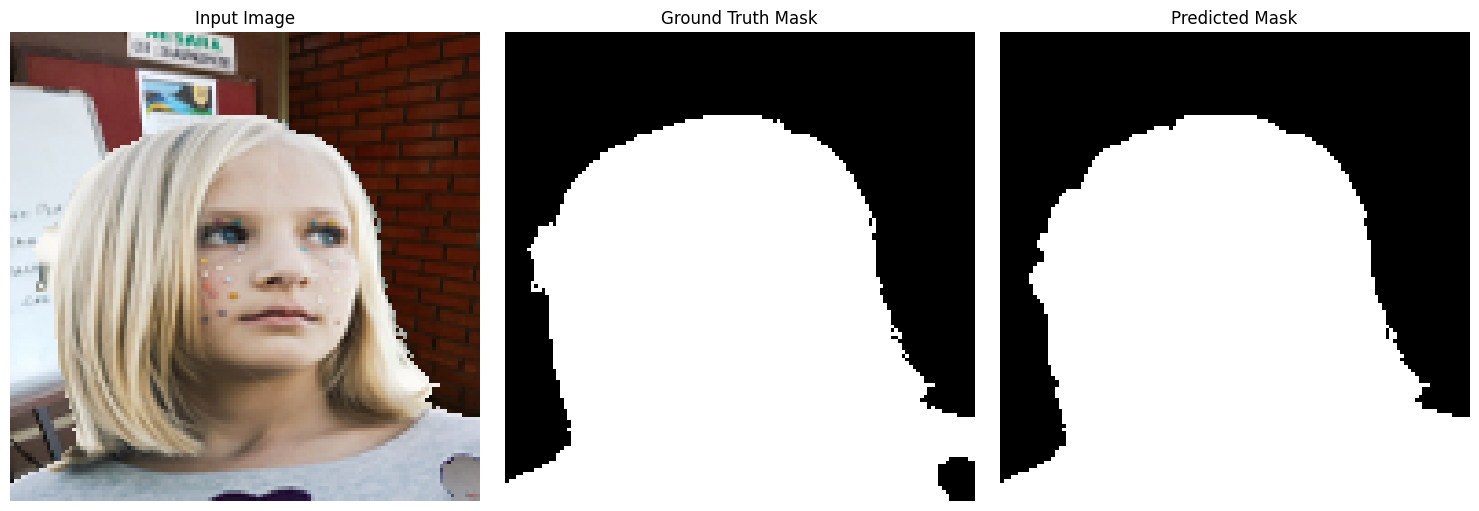

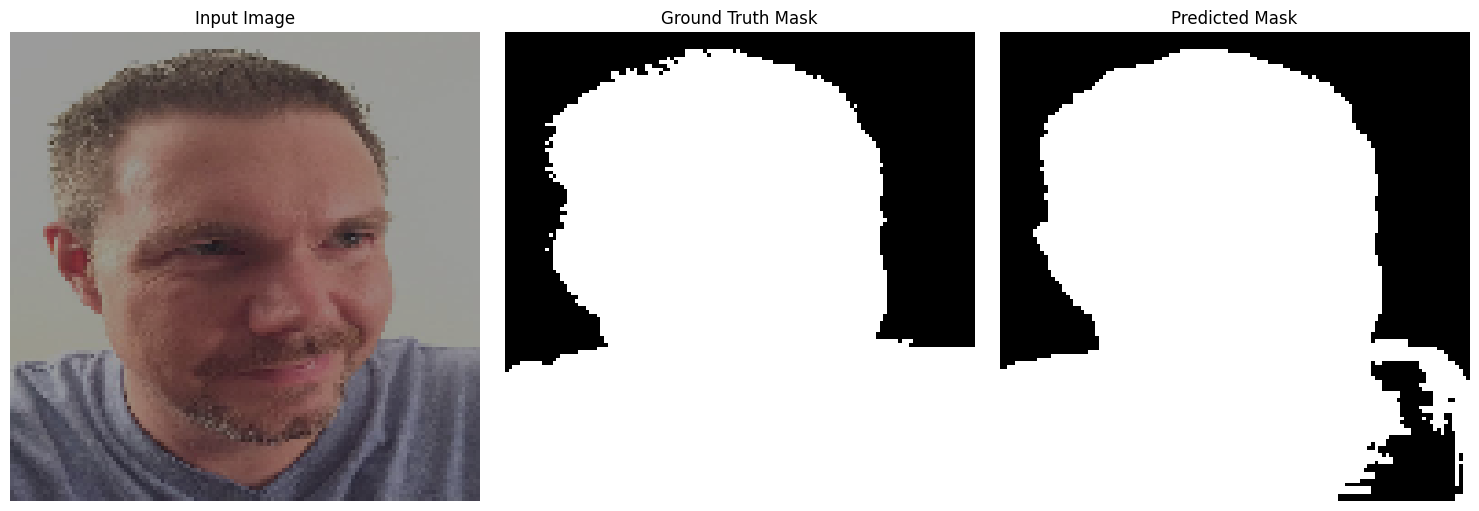

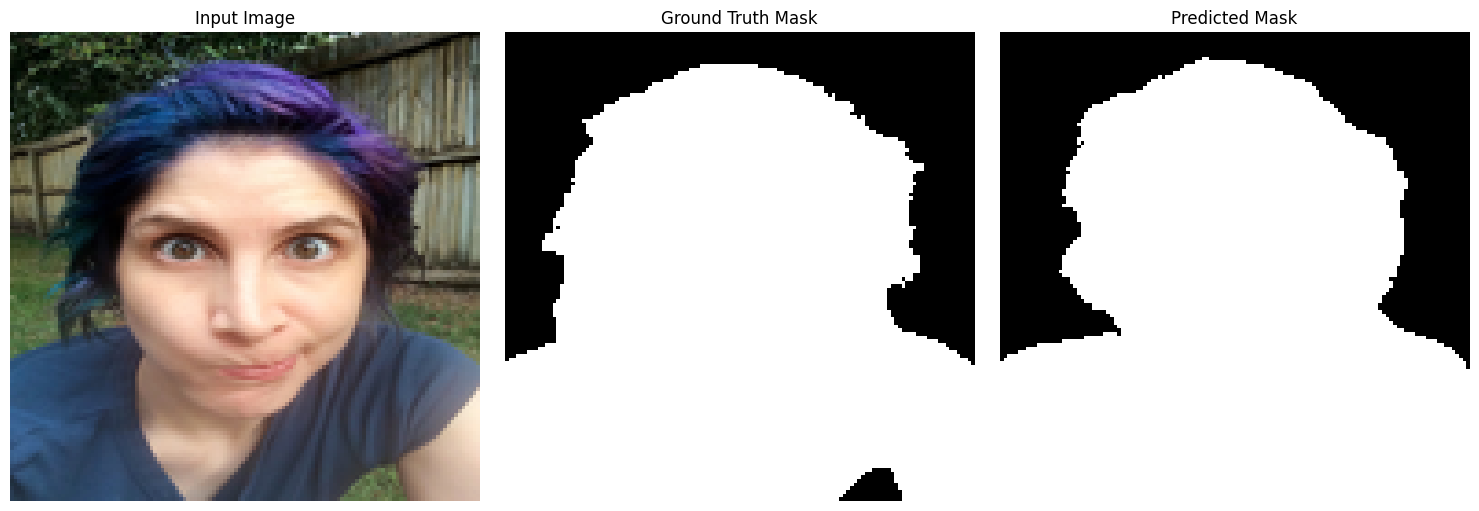

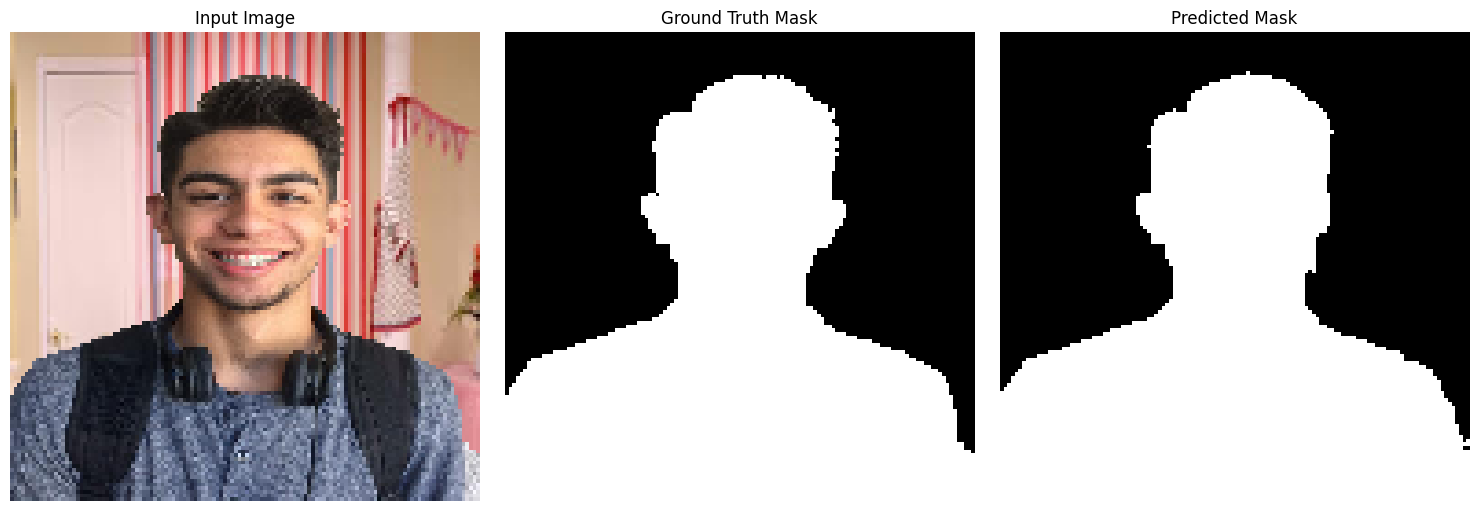

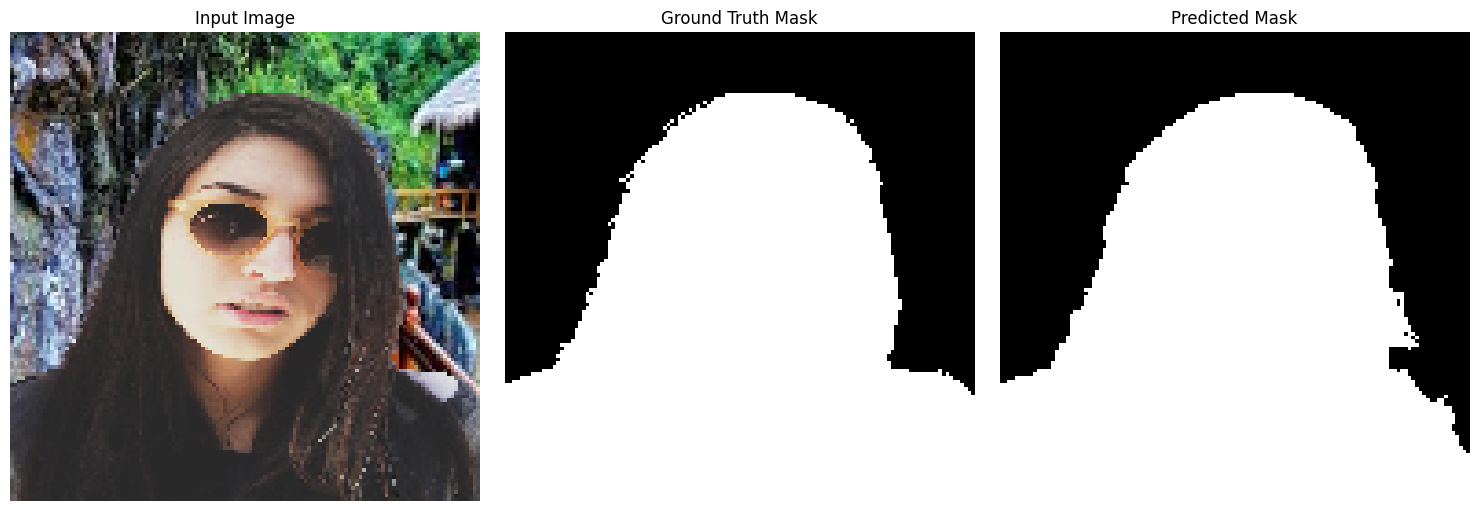

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.08157698810100555    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.08157698810100555}]

In [43]:
uNetTrainer.test(uNetTest, val_loader)

Conversion to Coreml

In [45]:
!pip install coremltools
import coremltools as ct

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.4 MB/s eta 0:00:00


In [47]:
traceableUnet = uNetTest.eval()
trace = torch.jit.trace(traceableUnet, torch.rand(1, 3, 128, 128))

<ipython-input-41-846d7a35dc94>:85: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if xup1.size() != xconv42.size():


In [50]:
coreMlModel = ct.convert(trace, inputs=[ct.ImageType(name="input", shape=(1,3,128,128))])

Running MIL default pipeline:   0%|          | 0/88 [00:00<?, ? passes/s]/usr/local/lib/python3.10/dist-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:273: UserWarning: Output, '347', of the source model, has been renamed to 'var_347' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 112.92 passes/s]


In [55]:
coreMlModel.save("/content/drive/MyDrive/!personalMLProject/portraitSegmentation/uNetModelCoreML.mlpackage")